### Читаем файл

In [47]:
with open('SMSSpamCollection.txt') as f:
  file_lines = f.readlines()
print(f"Line's count: {len(file_lines)}")

Line's count: 5574


### Парсим строки

In [48]:
SPAM = 'spam'
NOT_SPAM = 'not_spam'
parsed_lines = {SPAM: [], NOT_SPAM: []}
for line in file_lines:
  splitted_line = line.split(maxsplit=1)
  key = splitted_line[0] if splitted_line[0] != 'ham' else NOT_SPAM # хз что такое ham, меняем на not_spam
  value = splitted_line[1].replace('\n', ' ').replace('\t', ' ')
  parsed_lines[key].append(value) # будем надеяться, что со строчками всё ок и сделаем так ^_^
print(f"Check that parsed_lines containts only SPAM and NOT_SPAM: parsed_lines.keys() = {parsed_lines.keys()}")
print(f"Spam message's count: {len(parsed_lines['spam'])}\nNot spam message's count: {len(parsed_lines['not_spam'])}")
print(f"Spam example: \"{parsed_lines['spam'][0]}\"\nNot spam ex: \"{parsed_lines['not_spam'][0]}\"")

Check that parsed_lines containts only SPAM and NOT_SPAM: parsed_lines.keys() = dict_keys(['spam', 'not_spam'])
Spam message's count: 747
Not spam message's count: 4827
Spam example: "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's "
Not spam ex: "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... "


### Красивый графичек с отношением количества спама к количеству не спама

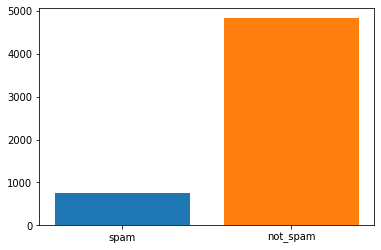

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.bar(SPAM, len(parsed_lines[SPAM]))
plt.bar(NOT_SPAM, len(parsed_lines[NOT_SPAM]))
plt.show()

### Используем pandas, чтобы удобно смотреть данные

In [50]:
import pandas as pd
LABEL = 'label'
MSG = 'message'

### Объединяем dict parsed_lines, чтобы записать в таблицу. Паралелльно чистим текст

In [51]:
def clean_text(text):
    return text.replace(r"http\S+", "") \
      .replace(r"http", "") \
      .replace(r"@\S+", "") \
      .replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ") \
      .replace(r"@", "at").lower()

import random
data_table = []
for spam_line in parsed_lines[SPAM]:
  data_table.append({LABEL: SPAM, MSG: clean_text(spam_line)})
for not_spam_line in parsed_lines[NOT_SPAM]:
  data_table.append({LABEL: NOT_SPAM, MSG: clean_text(not_spam_line)})
random.shuffle(data_table)

In [52]:
df = pd.DataFrame(data_table)
df

,label,message
0,not_spam,"playin space poker, u?"
1,not_spam,tessy..pls do me a favor. pls convey my birthd...
2,not_spam,"are you being good, baby? :)"
3,not_spam,hi baby im cruisin with my girl friend what r ...
4,not_spam,so gd got free ice cream... i oso wan...
...,...,...
5569,not_spam,yeah that's the impression i got
5570,not_spam,going for dinner.msg you after.
5571,not_spam,i wanna watch that movie
5572,spam,you have won a nokia 7250i. this is what you g...


In [53]:
df.groupby(LABEL).count()

,message
label,
not_spam,4827
spam,747


### Токенизируем текст

In [54]:
from nltk.tokenize import RegexpTokenizer

TOKENS = 'tokens'
tokenizer = RegexpTokenizer(r'\w+')

df[TOKENS] = df[MSG].apply(tokenizer.tokenize)
df.head()

,label,message,tokens
0,not_spam,"playin space poker, u?","[playin, space, poker, u]"
1,not_spam,tessy..pls do me a favor. pls convey my birthd...,"[tessy, pls, do, me, a, favor, pls, convey, my..."
2,not_spam,"are you being good, baby? :)","[are, you, being, good, baby]"
3,not_spam,hi baby im cruisin with my girl friend what r ...,"[hi, baby, im, cruisin, with, my, girl, friend..."
4,not_spam,so gd got free ice cream... i oso wan...,"[so, gd, got, free, ice, cream, i, oso, wan]"


### Немного больше информации о тексте, а именно длина сообщения

In [55]:
all_words = [word for tokens in df[TOKENS] for word in tokens]
sentence_lengths_spam = [len(tokens) for tokens in df.loc[df[LABEL] == SPAM][TOKENS]]
sentence_lengths_not_spam = [len(tokens) for tokens in df.loc[df[LABEL] == NOT_SPAM][TOKENS]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(max(sentence_lengths_spam), max(sentence_lengths_not_spam)))

90357 words total, with a vocabulary size of 8757
Max sentence length is 190


### Ещё один красивый графичек, красивых графичков много не бывает

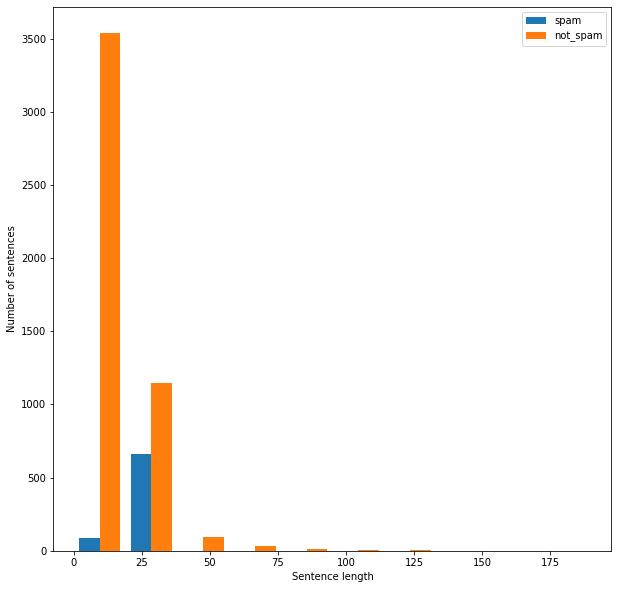

In [56]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist([sentence_lengths_spam, sentence_lengths_not_spam], label=[SPAM, NOT_SPAM])
plt.legend()
plt.show()

### Как видим большинство сообщений короткие, поэтому трудно сказать, но у спама только короткие

### Обычный LabelEncoder сюда не подойдет (ну можно, но сложно), воспользуемся CountVectorizer

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

### Разобьём данные на тестовую и тренировочную выборки

In [58]:
list_corpus = df[MSG].tolist()
list_labels = df[LABEL].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.3)

### Оценим соотношение СПАМА к НЕ_СПАМУ в выборках

In [59]:
spam_train_percents = round(y_train.count(SPAM)/len(y_train) * 100, 2)
spam_test_percents = round(y_test.count(SPAM)/len(y_test) * 100, 2)
not_spam_train_percents = round(y_train.count(NOT_SPAM)/len(y_train) * 100, 2)
not_spam_test_percents = round(y_test.count(NOT_SPAM)/len(y_test) * 100, 2)
print(f'Test: SPAM/NOT_SPAM = {spam_test_percents}/{not_spam_test_percents} %')
print(f'Train: SPAM/NOT_SPAM = {spam_train_percents}/{not_spam_train_percents} %')

Test: SPAM/NOT_SPAM = 13.69/86.31 %
Train: SPAM/NOT_SPAM = 13.28/86.72 %


### Закодируем слова

In [60]:
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)

### Выведем 10 закодированных слов

In [61]:
max_print = 10
for key, value in count_vectorizer.vocabulary_.items():
    if max_print <= 0:
        break
    max_print -= 1
    print(f'key={key}, value={value}')

key=go, value=2980
key=fool, value=2768
key=dont, value=2277
key=cheat, value=1677
key=others, value=4704
key=ok, value=4624
key=make, value=4064
key=sure, value=6214
key=alex, value=855
key=knows, value=3714


## Попробуем сначала *логистическую регрессию*

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
y_train_predict = clf.predict(X_train)

print("Результаты для тренировочной выборки")
print(classification_report(y_train, y_train_predict))
print("Результаты для тестовой выборки")
print(classification_report(y_test, y_predict))

Результаты для тренировочной выборки
              precision    recall  f1-score   support

    not_spam       1.00      1.00      1.00      3383
        spam       1.00      0.98      0.99       518

    accuracy                           1.00      3901
   macro avg       1.00      0.99      0.99      3901
weighted avg       1.00      1.00      1.00      3901

Результаты для тестовой выборки
              precision    recall  f1-score   support

    not_spam       0.98      1.00      0.99      1444
        spam       0.98      0.88      0.93       229

    accuracy                           0.98      1673
   macro avg       0.98      0.94      0.96      1673
weighted avg       0.98      0.98      0.98      1673



#### Дополнительное исследование

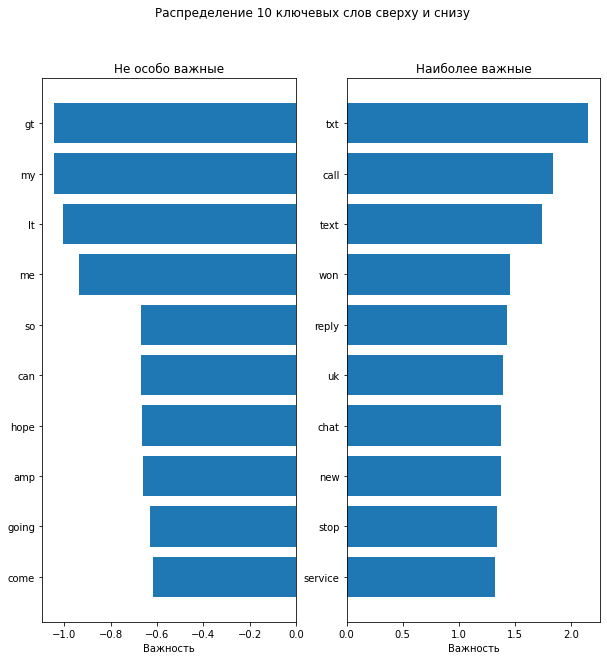

In [63]:
import numpy as np

index_to_word = {v: k for k, v in count_vectorizer.vocabulary_.items()}
importance = {}
n = 10
for class_index in range(clf.coef_.shape[0]):
    word_importances = [(el, index_to_word[i]) for i, el in enumerate(clf.coef_[class_index])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
    bottom = sorted_coeff[-n:]
    importance[class_index] = {
        'tops':tops,
        'bottom':bottom
    }

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

y_pos = np.arange(len(top_words))
top_pairs = zip(top_words, top_scores)
top_pairs = sorted(top_pairs, key=lambda x: x[1])

bottom_pairs = zip(bottom_words, bottom_scores)
bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize=(10, 10))  

plt.subplot(121)
plt.barh(y_pos,bottom_scores)
plt.title('Не особо важные')
plt.yticks(y_pos, bottom_words)
plt.suptitle('Ключевые слова')
plt.xlabel('Важность')

plt.subplot(122)
plt.barh(y_pos,top_scores)
plt.title('Наиболее важные')
plt.yticks(y_pos, top_words)
plt.suptitle('Распределение 10 ключевых слов сверху и снизу')
plt.xlabel('Важность')
plt.show()

### Можно увидеть справа слово 'won', что может означать "выигрыш" в какой-либо лотерее или игре, что конечно же является спамом.

## Теперь попробуем *Байеса*

In [64]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train, y_train)
y_train_predict = mnb.predict(X_train)
y_predict = mnb.predict(X_test)

print("Результаты для тренировочной выборки")
print(classification_report(y_train, y_train_predict))
print("Результаты для тестовой выборки")
print(classification_report(y_test, y_predict))

Результаты для тренировочной выборки
              precision    recall  f1-score   support

    not_spam       1.00      1.00      1.00      3383
        spam       0.98      0.97      0.98       518

    accuracy                           0.99      3901
   macro avg       0.99      0.98      0.99      3901
weighted avg       0.99      0.99      0.99      3901

Результаты для тестовой выборки
              precision    recall  f1-score   support

    not_spam       0.99      1.00      0.99      1444
        spam       0.97      0.93      0.95       229

    accuracy                           0.99      1673
   macro avg       0.98      0.96      0.97      1673
weighted avg       0.99      0.99      0.99      1673



### Видно, что Байес сработал немного лучше, чем логистическая регрессия

#### Дополнительное исследование

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


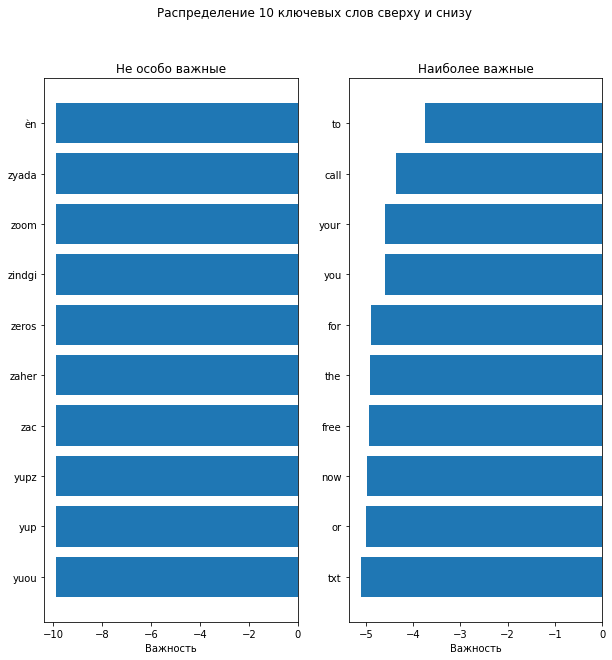

In [65]:
index_to_word = {v: k for k, v in count_vectorizer.vocabulary_.items()}
importance = {}
n = 10
for class_index in range(mnb.coef_.shape[0]):
    word_importances = [(el, index_to_word[i]) for i, el in enumerate(mnb.coef_[class_index])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
    bottom = sorted_coeff[-n:]
    importance[class_index] = {
        'tops':tops,
        'bottom':bottom
    }

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

y_pos = np.arange(len(top_words))
top_pairs = zip(top_words, top_scores)
top_pairs = sorted(top_pairs, key=lambda x: x[1])

bottom_pairs = zip(bottom_words, bottom_scores)
bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize=(10, 10))  

plt.subplot(121)
plt.barh(y_pos,bottom_scores)
plt.title('Не особо важные')
plt.yticks(y_pos, bottom_words)
plt.suptitle('Ключевые слова')
plt.xlabel('Важность')

plt.subplot(122)
plt.barh(y_pos,top_scores)
plt.title('Наиболее важные')
plt.yticks(y_pos, top_words)
plt.suptitle('Распределение 10 ключевых слов сверху и снизу')
plt.xlabel('Важность')
plt.show()